# Data Preprocessing for Retail Dataset
This notebook provides different methods for cleaning and preprocessing a retail dataset. You can choose different approaches based on your needs, such as filtering by date or maximizing the number of customers.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("../datasets/retail.csv")
print("Dataset Loaded.")
df.head()

Dataset Loaded.


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Handling Missing Values
### One way of handing missing values is to simply remove all the rows which contain missing values.

In [ ]:
df.dropna(inplace=True)

### Since we would like to keep most of the data, we will apply some default values when the missing values are not that important, or when the entries can still be used for other feature extracting.

In [4]:
fill_na = {
    "Description": "No description available",
    "Country": "Unknown",
    "Customer ID": 0,
    "Quantity": 0,
    "InvoiceDate": df["InvoiceDate"].min()
}
df.fillna(fill_na, inplace=True)

### When the Invoice or StockCode missing, we will discard the entries either way.

In [5]:
# Remove all transactions without Invoice and StockCode since these are important info
df.dropna(subset=["Invoice"], inplace=True)
df.dropna(subset=["StockCode"], inplace=True)

### When the price is missing, we will search for products with the same StockCode and take the price of that product.

In [6]:
def fill_price(row):
    if pd.isna(row["Price"]):
        # Find other prices for the same StockCode
        stock_prices = df[df["StockCode"] == row["StockCode"]]["Price"].dropna()

        if not stock_prices.empty:
            return stock_prices.median()
        else:
            print("sad")
            return np.nan
    return row["Price"]

df["Price"] = df.apply(fill_price, axis=1)



### When the quantity of a transaction is negative, we assume that the product is returned and thus we can remove the entries.

In [7]:
df = df.loc[df["Quantity"] >= 0].copy()

## Filtering Dataset
### I created a function where you can choose on what to filter, and have the option to choose a random interval/selection

In [8]:
def prune_dataset(df, column, param, random=False):
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

    # Filter by InvoiceDate
    if column == "InvoiceDate":
        min_date, max_date = df["InvoiceDate"].min(), df["InvoiceDate"].max()

        if random:
            start_date = np.random.choice(pd.date_range(min_date, max_date - pd.Timedelta(days=param)))
            df = df[(df["InvoiceDate"] >= start_date) & (df["InvoiceDate"] < start_date + pd.Timedelta(days=param))]
        else:
            latest_date = df["InvoiceDate"].max()
            df = df[df["InvoiceDate"] >= latest_date - pd.Timedelta(days=param)]

    # Filter by Customer ID
    elif column == "Customer ID":
        unique_customers = df["Customer ID"].unique()
        if random:
            selected_customers = np.random.choice(unique_customers, min(param, len(unique_customers)), replace=False)
        else:
            selected_customers = df["Customer ID"].value_counts().nlargest(param).index
        df = df[df["Customer ID"].isin(selected_customers)]

    # Filter by InvoiceNo
    elif column == "InvoiceNo":
        unique_invoices = df["InvoiceNo"].unique()
        if random:
            selected_invoices = np.random.choice(unique_invoices, min(param, len(unique_invoices)), replace=False)
        else:
            selected_invoices = df["InvoiceNo"].value_counts().nlargest(param).index
        df = df[df["InvoiceNo"].isin(selected_invoices)]

    return df

### You can now for example say you want the 30 last days of data

In [9]:
df = prune_dataset(df, "InvoiceDate", 30, False)

### Or say you want maximum 30 customers

In [ ]:
df = prune_dataset(df, "Customer ID", 30, True)

## Feature Engineering
### Categorizing Time of Day

In [10]:
def categorize_time(hour):
    if 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour < 24:
        return "Evening"
    else:
        return "Night"

# Convert InvoiceDate to datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df["TimeCategory"] = df["InvoiceDate"].dt.hour.apply(categorize_time)

df["DayOfWeek"] = df["InvoiceDate"].dt.day_name()

### Categorizing Price and Quantity

In [11]:
df["PriceCategory"] = pd.qcut(df["Price"], q=3, labels=["Cheap", "Mid-Range", "Expensive"], duplicates="drop")
df["QuantityCategory"] = pd.qcut(df["Quantity"], q=3, labels=["Small", "Medium", "Large"], duplicates="drop")

## Save Cleaned Dataset

In [12]:
df.to_csv("../datasets/cleaned_retail.csv", index=False)
print("Preprocessing complete. Cleaned dataset saved as 'cleaned_retail.csv'.")

Preprocessing complete. Cleaned dataset saved as 'cleaned_retail.csv'.


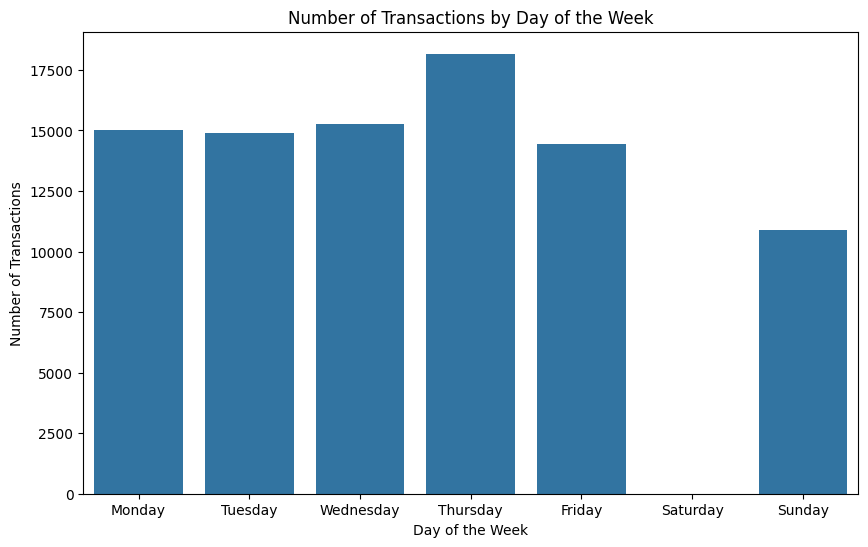

In [13]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x="DayOfWeek", data=df, order=[
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])
plt.title("Number of Transactions by Day of the Week")
plt.ylabel("Number of Transactions")
plt.xlabel("Day of the Week")
plt.show()

/tmp/ipykernel_75484/1282793274.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="PriceCategory", y="TotalSales", data=df, estimator=sum, ci=None)


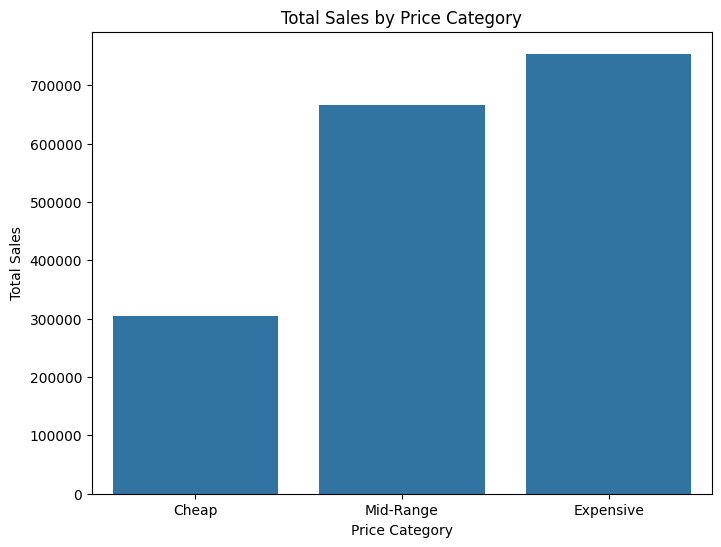

In [19]:
df["TotalSales"] = df["Price"] * df["Quantity"]

plt.figure(figsize=(8, 6))
sns.barplot(x="PriceCategory", y="TotalSales", data=df, estimator=sum, ci=None)
plt.title("Total Sales by Price Category")
plt.ylabel("Total Sales")
plt.xlabel("Price Category")
plt.show()

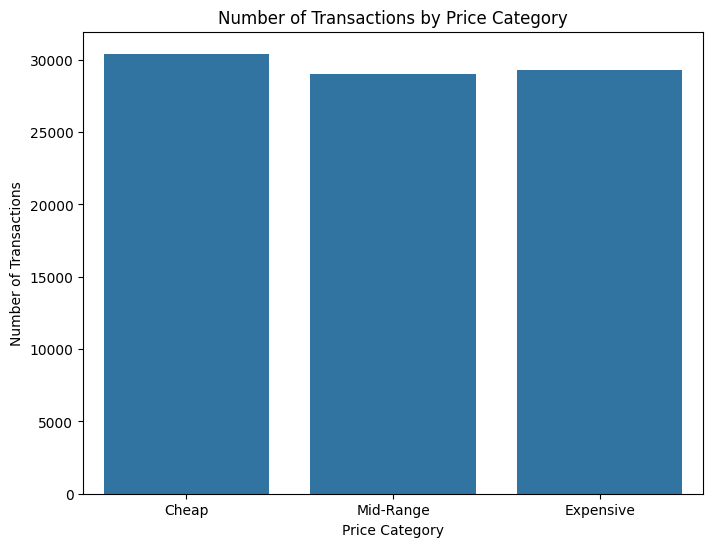

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(x="PriceCategory", data=df)
plt.title("Number of Transactions by Price Category")
plt.ylabel("Number of Transactions")
plt.xlabel("Price Category")
plt.show()

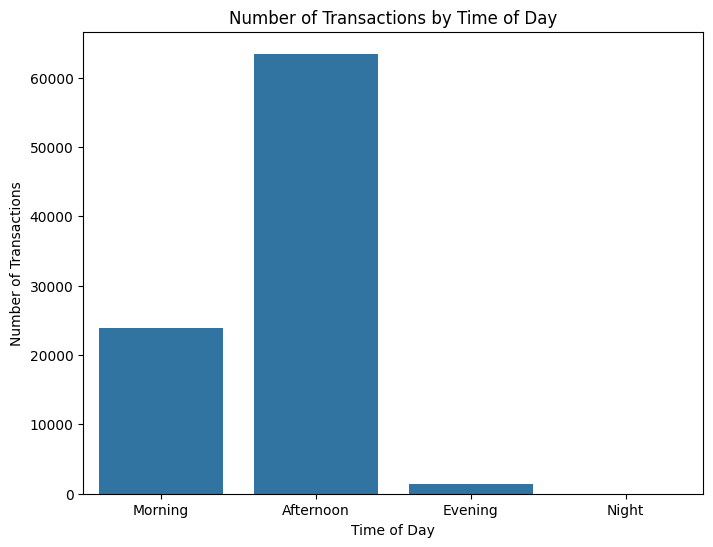

In [16]:
plt.figure(figsize=(8, 6))
sns.countplot(x="TimeCategory", data=df, order=["Morning", "Afternoon", "Evening", "Night"])
plt.title("Number of Transactions by Time of Day")
plt.ylabel("Number of Transactions")
plt.xlabel("Time of Day")
plt.show()

/tmp/ipykernel_75484/1425144228.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="TimeCategory", y="Price", data=df, estimator=sum, ci=None,


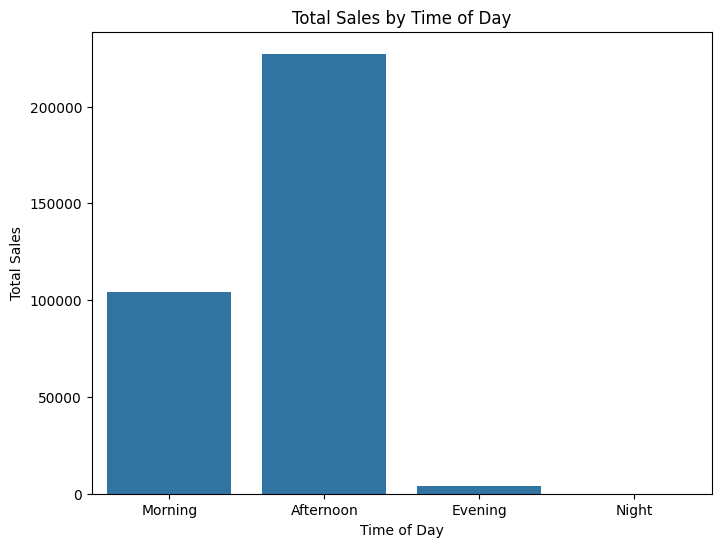

In [17]:
plt.figure(figsize=(8, 6))
sns.barplot(x="TimeCategory", y="Price", data=df, estimator=sum, ci=None,
            order=["Morning", "Afternoon", "Evening", "Night"])
plt.title("Total Sales by Time of Day")
plt.ylabel("Total Sales")
plt.xlabel("Time of Day")
plt.show()

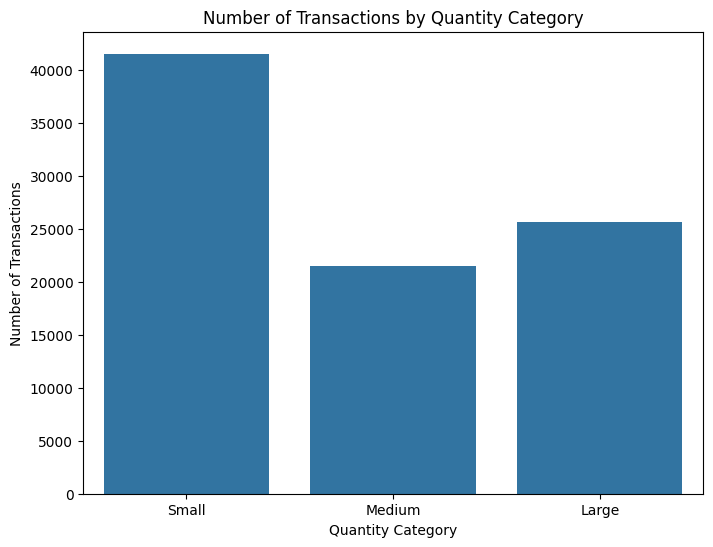

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x="QuantityCategory", data=df)
plt.title("Number of Transactions by Quantity Category")
plt.ylabel("Number of Transactions")
plt.xlabel("Quantity Category")
plt.show()

##Most basic case of rules

Rule: ["PAPER CHAIN KIT 50'S CHRISTMAS ", '12 PENCIL SMALL TUBE WOODLAND'] | Support: 0.020868394479973074
  frozenset({'12 PENCIL SMALL TUBE WOODLAND'}) -> frozenset({"PAPER CHAIN KIT 50'S CHRISTMAS "}) | Confidence: 0.496 | Lift: 3.533851318944844
--------------------------------------------------
Rule: ['SET 12 COLOUR PENCILS SPACEBOY ', '12 PENCIL SMALL TUBE WOODLAND'] | Support: 0.020868394479973074
  frozenset({'12 PENCIL SMALL TUBE WOODLAND'}) -> frozenset({'SET 12 COLOUR PENCILS SPACEBOY '}) | Confidence: 0.496 | Lift: 11.07981954887218
  frozenset({'SET 12 COLOUR PENCILS SPACEBOY '}) -> frozenset({'12 PENCIL SMALL TUBE WOODLAND'}) | Confidence: 0.46616541353383456 | Lift: 11.07981954887218
--------------------------------------------------
Rule: ["ROLL WRAP 50'S CHRISTMAS", "6 GIFT TAGS 50'S CHRISTMAS "] | Support: 0.02255132951868058
  frozenset({"6 GIFT TAGS 50'S CHRISTMAS "}) -> frozenset({"ROLL WRAP 50'S CHRISTMAS"}) | Confidence: 0.5826086956521739 | Lift: 11.463115462136

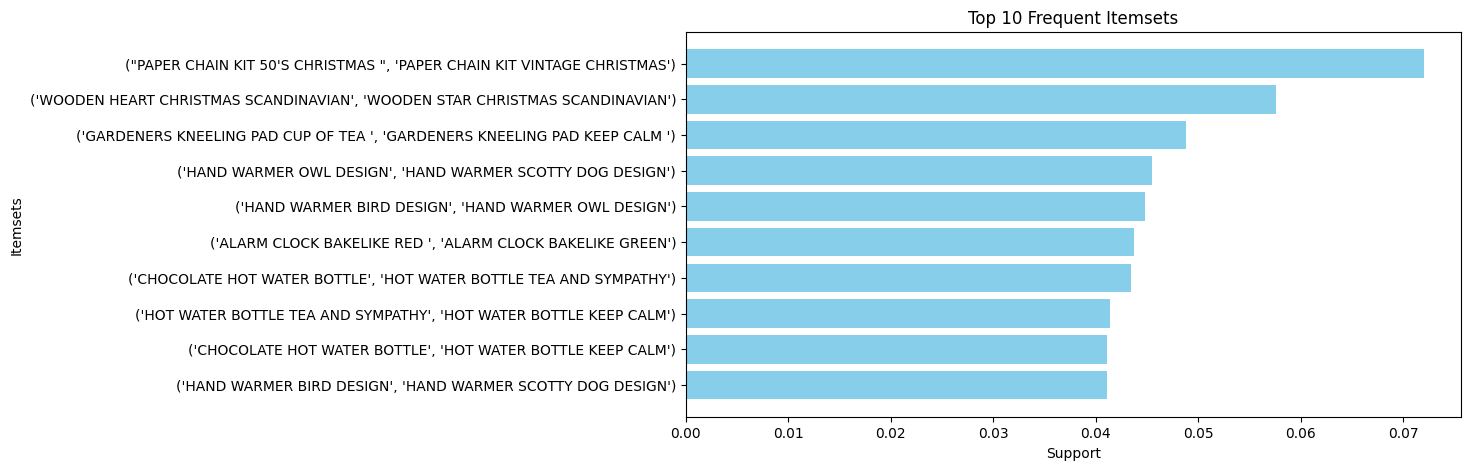

In [21]:
from apyori import apriori
df = pd.read_csv('../datasets/cleaned_retail.csv')

# Convert Invoice to string (important for grouping)
df["Invoice"] = df["Invoice"].astype(str)

# Remove duplicates (some invoices contain the same product multiple times)
df = df.drop_duplicates(subset=["Invoice", "StockCode"])

# Group by Invoice and aggregate items into a list
transactions = df.groupby("Invoice")["Description"].apply(list).tolist()

frequent_itemsets = apriori(transactions, min_support=0.02, min_confidence=0.3, min_lift=1.1, min_length=2)

# Convert the results into a list
results = list(frequent_itemsets)

# Print the first few rules
for rule in results[:15]:
    items = [x for x in rule.items]
    print(f"Rule: {items} | Support: {rule.support}")

    for ordered_stat in rule.ordered_statistics:
        print(
            f"  {ordered_stat.items_base} -> {ordered_stat.items_add} | Confidence: {ordered_stat.confidence} | Lift: {ordered_stat.lift}")
    print("-" * 50)


rules_list = []
for rule in results:
    items = tuple(rule.items)
    support = rule.support
    rules_list.append([items, support])

# Convert to DataFrame
df_frequent = pd.DataFrame(rules_list, columns=["Itemset", "Support"])

# Ensure 'Support' column is of type float
df_frequent["Support"] = pd.to_numeric(df_frequent["Support"], errors="coerce")

# Now, sort by support
top_items = df_frequent.nlargest(10, "Support")

# Plot top frequent itemsets
plt.figure(figsize=(10, 5))
plt.barh([str(item) for item in top_items["Itemset"]], top_items["Support"], color="skyblue")
plt.xlabel("Support")
plt.ylabel("Itemsets")
plt.title("Top 10 Frequent Itemsets")
plt.gca().invert_yaxis()  # Show highest on top
plt.show()